# ex013
5-fold

In [1]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

# config

In [2]:
BASE_DIR = "/working/"
EXP_NAME = "exp013"
OUTPUT_DIR = os.path.join(BASE_DIR, "output", EXP_NAME)

4
[range(26, 36, 3), range(27, 37, 3), range(25, 35, 3)]
SLIDE_POS_LIST = [[0, 0], [128, 0], [0, 128], [128, 128]]


# metric

In [3]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

# main

---
# OOF SCORE CHECK

/working/output/exp013/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


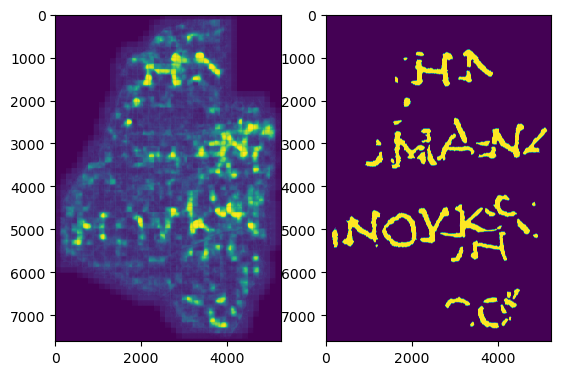

/working/output/exp013/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


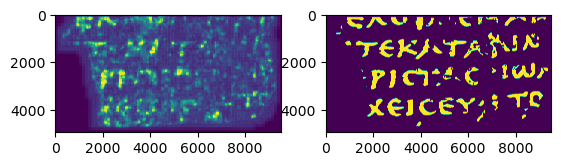

/working/output/exp013/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


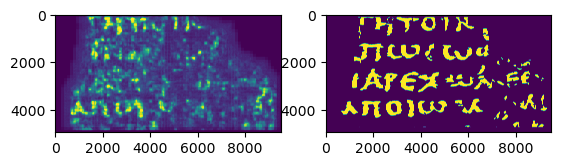

/working/output/exp013/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


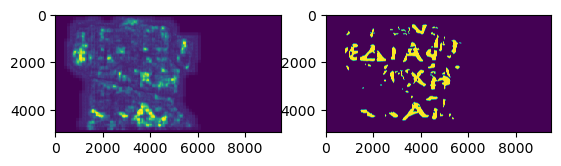

/working/output/exp013/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


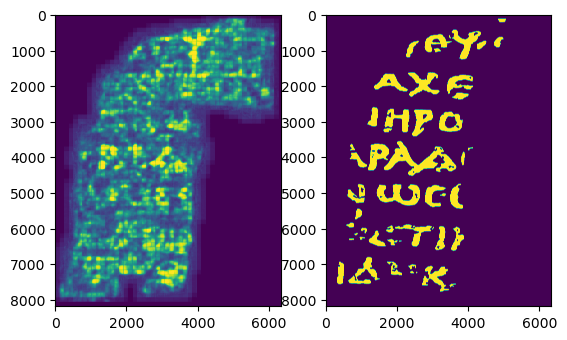

CPU times: user 17.9 s, sys: 7.96 s, total: 25.9 s
Wall time: 24 s


In [5]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

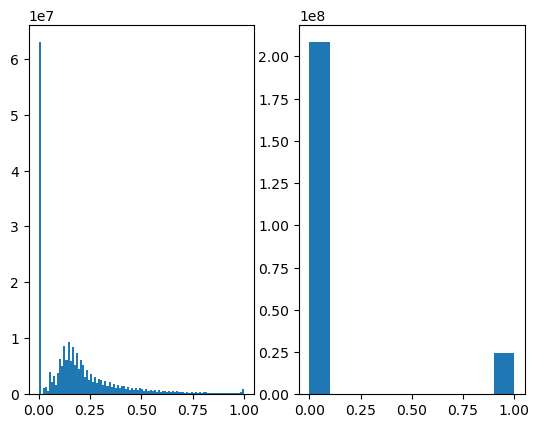

th=0.10, dice=0.1924
th=0.15, dice=0.2361
th=0.20, dice=0.2876
th=0.25, dice=0.3361
th=0.30, dice=0.3747
th=0.35, dice=0.4083
th=0.40, dice=0.4344
th=0.45, dice=0.4563
th=0.50, dice=0.4732
th=0.55, dice=0.4849
th=0.60, dice=0.4909
th=0.65, dice=0.4905
th=0.70, dice=0.4816
th=0.75, dice=0.4646
th=0.80, dice=0.4399
th=0.85, dice=0.4034
th=0.90, dice=0.3494
th=0.95, dice=0.2630
th=1.00, dice=0.0881


In [6]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")

In [7]:
threshols =[0.650000, 0.50000, 0.50000, 0.550000, 0.80000]
print(np.mean(threshols))

0.6


: 